## Summary of Notebook

This notebook contains the implementation of the EfficientNetB0 model with ECA implementation. It provides the results obtained from this model and its performance across the training, validation, and testing phases.

## Set Up
Here, we will begin by downloading the necessary dataset for flowers102, followed by the creation of dataloaders and the implementation of train and test functions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from scipy.io import loadmat
import pandas as pd
from torch.utils.data import Dataset
import json

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
train_dataset = torchvision.datasets.Flowers102("./data/train", split="train", download=True, transform=data_transforms["train"])
val_dataset = torchvision.datasets.Flowers102("./data/val", split="val", download=True, transform=data_transforms["val"])
test_dataset = torchvision.datasets.Flowers102("./data/test", split="test", download=True, transform=data_transforms["test"])

100%|██████████| 344862509/344862509 [00:13<00:00, 24893589.54it/s]


Extracting data/train/flowers-102/102flowers.tgz to data/train/flowers-102


100%|██████████| 502/502 [00:00<00:00, 581480.42it/s]


100%|██████████| 14989/14989 [00:00<00:00, 25514781.92it/s]


100%|██████████| 344862509/344862509 [00:18<00:00, 18837211.07it/s]


Extracting data/val/flowers-102/102flowers.tgz to data/val/flowers-102


100%|██████████| 502/502 [00:00<00:00, 448368.95it/s]


100%|██████████| 14989/14989 [00:00<00:00, 11784146.70it/s]


100%|██████████| 344862509/344862509 [00:14<00:00, 23775688.84it/s]


Extracting data/test/flowers-102/102flowers.tgz to data/test/flowers-102


100%|██████████| 502/502 [00:00<00:00, 400521.33it/s]


100%|██████████| 14989/14989 [00:00<00:00, 24386509.95it/s]


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
dataloaders = {}
dataloaders["train"] = train_dataloader
dataloaders["val"] = val_dataloader
dataloaders["test"] = test_dataloader

In [ ]:
dataset_sizes = {}
dataset_sizes["train"] = len(train_dataloader.dataset)
dataset_sizes["val"] = len(val_dataloader.dataset)
dataset_sizes["test"] = len(test_dataloader.dataset)

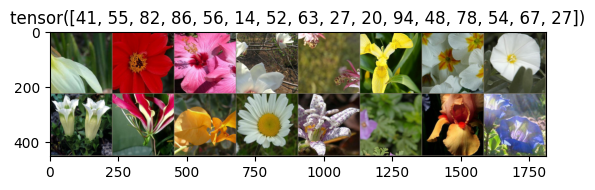

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes)



In [ ]:
def test_model(model, criterion):
  running_loss = 0.0
  running_corrects = 0
  for inputs, labels in dataloaders["test"]:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
  total_loss = running_loss / dataset_sizes["test"]
  total_acc = running_corrects.double() / dataset_sizes["test"]
  return total_loss, total_acc

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_accuracies = []
    val_accuracies = []
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                if phase == "train":
                  train_accuracies.append(epoch_acc)
                else:
                  val_accuracies.append(epoch_acc)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, train_accuracies, val_accuracies

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model_conv = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model_conv = efficientnet_b0(weights="DEFAULT")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 70.5MB/s]


### Modify the Architecture (Replacing Squeeze-and-Excitation to Efficient Channel Attention in each MBCONV)

In this section, we will replace all the squeeze-and-excitation modules in each of the MBCONV blocks in the EfficientNetB0 with the more lightweight Efficient Channel Attention module.

In [ ]:
model_a= efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model_a = efficientnet_b0(weights="DEFAULT")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import math
class ECA(nn.Module):
    """Constructs a ECA module.


    Args:
        channels: Number of channels in the input tensor
        b: Hyper-parameter for adaptive kernel size formulation. Default: 1
        gamma: Hyper-parameter for adaptive kernel size formulation. Default: 2
    """
    def __init__(self, channels, b=1, gamma=2):
        super(ECA, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channels = channels
        self.b = b
        self.gamma = gamma
        self.conv = nn.Conv1d(1, 1, kernel_size=self.kernel_size(), padding=(self.kernel_size() - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()


    def kernel_size(self):
        k = int(abs((math.log2(self.channels)/self.gamma)+ self.b/self.gamma))
        out = k if k % 2 else k+1
        return out


    def forward(self, x):


        # feature descriptor on the global spatial information
        y = self.avg_pool(x)


        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)


        # Multi-scale information fusion
        y = self.sigmoid(y)


        return x * y.expand_as(x)


In [ ]:
# replacing each SE with ECA in MBCONV
model_a.features[1][0].block[1] = ECA(32)
model_a.features[2][0].block[2] = ECA(96)
model_a.features[2][1].block[2] = ECA(96)
model_a.features[3][0].block[2] = ECA(144)
model_a.features[3][1].block[2] = ECA(240)
model_a.features[4][0].block[2] = ECA(240)
model_a.features[4][1].block[2] = ECA(480)
model_a.features[4][2].block[2] = ECA(480)
model_a.features[5][0].block[2] = ECA(480)
model_a.features[5][1].block[2] = ECA(672)
model_a.features[5][2].block[2] = ECA(672)
model_a.features[6][0].block[2] = ECA(672)
model_a.features[6][1].block[2] = ECA(1152)
model_a.features[6][2].block[2] = ECA(1152)
model_a.features[6][3].block[2] = ECA(1152)
model_a.features[7][0].block[2] = ECA(1152)

In [ ]:
model_a.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): ECA(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (sigmoid): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
num_ftrs = model_a.classifier[1].in_features


model_a.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_ftrs, 102),
        )


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_a = optim.SGD(model_a.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_a, step_size=7, gamma=0.1)

In [ ]:
model_a, train_accuracies_a, val_accuracies_a = train_model(model_a, criterion, optimizer_a, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 4.4295 Acc: 0.0520
val Loss: 3.7998 Acc: 0.2039

Epoch 1/24
----------
train Loss: 3.4237 Acc: 0.2255
val Loss: 3.2470 Acc: 0.2833

Epoch 2/24
----------
train Loss: 2.4448 Acc: 0.4167
val Loss: 1.6720 Acc: 0.5804

Epoch 3/24
----------
train Loss: 1.6581 Acc: 0.6000
val Loss: 2.3100 Acc: 0.4176

Epoch 4/24
----------
train Loss: 1.2979 Acc: 0.6765
val Loss: 1.3847 Acc: 0.6363

Epoch 5/24
----------
train Loss: 0.9813 Acc: 0.7471
val Loss: 2.0257 Acc: 0.4873

Epoch 6/24
----------
train Loss: 0.8825 Acc: 0.7804
val Loss: 0.8157 Acc: 0.7824

Epoch 7/24
----------
train Loss: 0.5977 Acc: 0.8627
val Loss: 0.5635 Acc: 0.8422

Epoch 8/24
----------
train Loss: 0.4876 Acc: 0.8902
val Loss: 0.5186 Acc: 0.8549

Epoch 9/24
----------
train Loss: 0.4629 Acc: 0.9029
val Loss: 0.5058 Acc: 0.8716

Epoch 10/24
----------
train Loss: 0.4107 Acc: 0.9235
val Loss: 0.4814 Acc: 0.8824

Epoch 11/24
----------
train Loss: 0.4520 Acc: 0.9020
val Loss: 0.4618 Acc: 0.8784

Ep

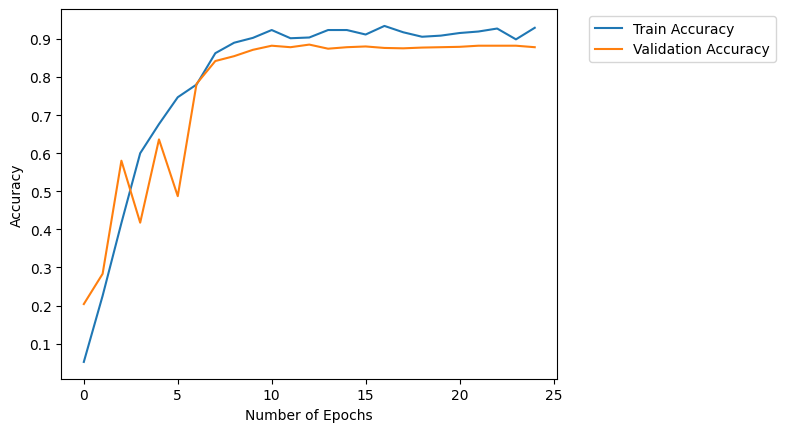

In [ ]:
plt.plot(range(25), train_accuracies_a, label="Train Accuracy")
plt.plot(range(25), val_accuracies_a, label="Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.yticks(np.arange(0.1, 1, 0.1))
plt.show()

In [ ]:
train_accuracy_list = []
for i in range(25):
  train_accuracy_list.append(train_accuracies_a[i].item())
train_accuracy_list

[0.05196078431372549,
 0.22549019607843138,
 0.4166666666666667,
 0.6,
 0.6764705882352942,
 0.7470588235294118,
 0.7803921568627451,
 0.8627450980392157,
 0.8901960784313725,
 0.9029411764705882,
 0.9235294117647059,
 0.9019607843137255,
 0.903921568627451,
 0.9235294117647059,
 0.9235294117647059,
 0.9117647058823529,
 0.9343137254901961,
 0.9176470588235294,
 0.9058823529411765,
 0.9088235294117647,
 0.9156862745098039,
 0.9196078431372549,
 0.9274509803921569,
 0.8990196078431373,
 0.9294117647058824]

In [ ]:
val_accuracy_list = []
for i in range(25):
  val_accuracy_list.append(val_accuracies_a[i].item())
val_accuracy_list

[0.20392156862745098,
 0.2833333333333333,
 0.5803921568627451,
 0.4176470588235294,
 0.6362745098039215,
 0.4872549019607843,
 0.7823529411764706,
 0.842156862745098,
 0.8549019607843137,
 0.8715686274509804,
 0.8823529411764706,
 0.8784313725490196,
 0.8852941176470588,
 0.8745098039215686,
 0.8784313725490196,
 0.8803921568627451,
 0.8764705882352941,
 0.8754901960784314,
 0.8774509803921569,
 0.8784313725490196,
 0.8794117647058823,
 0.8823529411764706,
 0.8823529411764706,
 0.8823529411764706,
 0.8784313725490196]

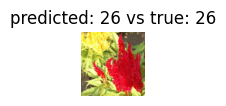

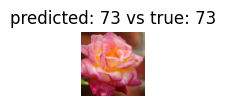

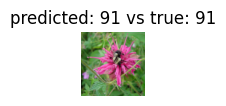

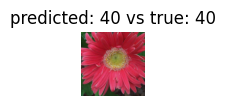

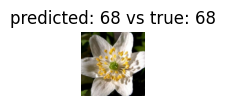

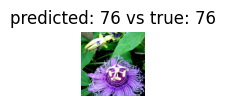

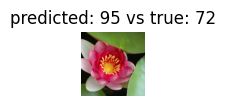

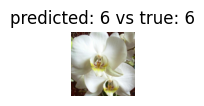

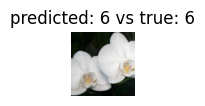

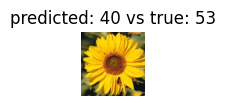

In [ ]:
visualize_model(model_a, num_images=10)

In [ ]:
torch.save(model_a, "/content/drive/MyDrive/SC4001/Team Project/EfficientNetB0/ECA.pth")

In [ ]:
model_a = torch.load("/content/drive/MyDrive/SC4001/Team Project/EfficientNetB0/PreTrain.pth")

### Comparison with different models

In [ ]:
# test accuracies for the 3 models
criterion = nn.CrossEntropyLoss()
loss_a, accuracy_a = test_model(model_a, criterion)

In [3]:
print(f"{ 'Test Loss (ECA)'.ljust(30) } : {loss_a:.4f}")
print(f"{ 'Test Accuracy (ECA)'.ljust(30) } : {accuracy_a:.4f}")

Test Loss (ECA)                : 0.4610
Test Accuracy (ECA)            : 0.8787
